In [24]:
import numpy as np
import pickle
import statistics

from xgboost import XGBClassifier
from sympy.core.numbers import igcd
from datetime import datetime

from sklearn import preprocessing
from sklearn import svm
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler,QuantileTransformer,RobustScaler,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import random
from scipy import stats

from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF
from pyod.models.loci import LOCI
from pyod.models.xgbod import XGBOD
from pyod.models.cof import COF
from pyod.models.loda import LODA
from pyod.models.copod import COPOD
from pyod.models.sod import SOD
from pyod.models.vae import VAE
from pyod.models.lof import LocalOutlierFactor,LOF
from pyod.models.lscp import LSCP
from pyod.models.so_gaal import SO_GAAL
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder

from keras.models import Sequential
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout,LSTM, Conv1D, MaxPooling1D, AveragePooling1D, Flatten,Reshape,UpSampling1D
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.manifold import TSNE
os.environ["CUDA_VISIBLE_DEVICES"] = "2"


In [25]:
#Generates the autoencoder 
def gen_autoencoder(X_train,encoding_dim):
    
    input_dim = X_train.shape[1] # the # features

    input_layer = Input(shape=(input_dim, ))
    hidden = Dense(encoding_dim[0], activation="relu")(input_layer)
    for n_neurons in encoding_dim[1:]:
        hidden = Dense(n_neurons, activation="relu")(hidden)#, activity_regularizer=regularizers.l1(10e-5))(input_layer)    
        #hidden = Dropout(0.5)(hidden)
    
    hidden = Dense(input_dim)(hidden)
    
    autoencoder = Model(inputs=input_layer, outputs=hidden)
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    autoencoder.compile(loss='mean_squared_error', optimizer = opt,metrics=['acc'])
    return autoencoder

#Get anomaly threshold from "autoencoder" setting the threshold in Q1,Q3+-1.5IQR
def get_threshold_mse_iqr(autoencoder,train_data):
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    iqr = np.quantile(mse,0.75) - np.quantile(mse, 0.25)
    up_bound = np.quantile(mse,0.75) + 1.5*iqr
    bottom_bound = np.quantile(mse,0.25) - 1.5*iqr
    thres = [up_bound,bottom_bound]
    return thres

#Get anomaly threshold from "autoencoder" setting the threshold in "train_data" using "outlier_percentage"
def get_threshold_mse_percentage(autoencoder,train_data,outlier_percentage):
    train_predicted = autoencoder.predict(train_data)
    mse = np.mean(np.power(train_data - train_predicted, 2), axis=1)
    thresh = np.quantile(mse, 1-outlier_percentage)
    return thresh

#Predict outliers in "df" using "autoencoder" model and "threshold_mse" as anomaly limit
def detect_outliers(autoencoder, df, threshold_mse):
    if(len(threshold_mse)==2):
        return detect_outliers_range(autoencoder, df, threshold_mse)
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    model.save('anomaly_Det.h5')
    #plt.hist(mse, bins=100)
    #plt.show()
    outliers = [np.array(mse) < threshold_mse]
    return outliers

def detect_outliers_range(autoencoder, df, threshold_mse):
    pred=autoencoder.predict(df)
    mse = np.mean(np.power(df - pred, 2), axis=1)
    up_bound = threshold_mse[0]
    bottom_bound = threshold_mse[1]
    outliers = [(np.array(mse) < up_bound)&(np.array(mse) > bottom_bound)]
    return outliers
    

In [26]:
def plot_hist(data):
    fig,ax = plt.subplots()
    fig.set_size_inches(10.5, 7.5, forward=True)
    plt.hist(data, bins = 1000)
    plt.show()

In [27]:
# Data load
df_0=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_0.csv")
df_1=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_1.csv")
df_2=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_2.csv")
df_3=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_3.csv")
df_4=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_4.csv")
df_5=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_5.csv")
df_6=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_6.csv")
df_mix=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_normal_all.csv")

In [28]:
# Filter vectors according to the timestamps

df_0 = df_0.loc[(df_0['timestamp'] >= 1615419435000) & (df_0['timestamp'] <= 1615451520000)]
df_1 = df_1.loc[(df_1['timestamp'] >= 1615925651000) & (df_1['timestamp'] <= 1615929569000)]
df_2 = df_2.loc[(df_2['timestamp'] >= 1615930017000) & (df_2['timestamp'] <= 1615933673000)]
df_3 = df_3.loc[(df_3['timestamp'] >= 1615969307000) & (df_3['timestamp'] <= 1615972800000)]
df_4 = df_4.loc[(df_4['timestamp'] >= 1615974874000) & (df_4['timestamp'] <= 1615978500000)]
df_5 = df_5.loc[(df_5['timestamp'] >= 1615978899000) & (df_5['timestamp'] <= 1615982700000)]
df_6 = df_6.loc[(df_6['timestamp'] >= 1615989015000) & (df_6['timestamp'] <= 1615992622000)]
df_mix = df_mix.loc[(df_mix['timestamp'] >= 1615996500000) & (df_mix['timestamp'] <= 1616005200000)]

In [29]:
#df_0.describe()

In [30]:
df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_mix])
#df = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6])
#df= pd.concat([df_0, df_1, df_2, df_3, df_4])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5353 entries, 7 to 759
Data columns (total 82 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   time                                     5353 non-null   float64
 1   timestamp                                5353 non-null   int64  
 2   seconds                                  5353 non-null   float64
 3   connectivity                             5353 non-null   int64  
 4   alarmtimer:alarmtimer_fired              5353 non-null   int64  
 5   alarmtimer:alarmtimer_start              5353 non-null   int64  
 6   block:block_bio_backmerge                5353 non-null   int64  
 7   block:block_bio_remap                    5353 non-null   int64  
 8   block:block_dirty_buffer                 5353 non-null   int64  
 9   block:block_getrq                        5353 non-null   int64  
 10  block:block_touch_buffer                 5353 non

In [32]:
df = df.loc[(df['connectivity']==1)]

In [33]:
# Remove columns with constant values
df=df.loc[:, (df != df.iloc[0]).any()]

In [34]:
df.describe()

,time,timestamp,seconds,block:block_bio_backmerge,block:block_bio_remap,block:block_dirty_buffer,block:block_getrq,block:block_touch_buffer,block:block_unplug,clk:clk_set_rate,...,writeback:sb_clear_inode_writeback,writeback:wbc_writepage,writeback:writeback_dirty_inode,writeback:writeback_dirty_inode_enqueue,writeback:writeback_dirty_page,writeback:writeback_mark_inode_dirty,writeback:writeback_pages_written,writeback:writeback_single_inode,writeback:writeback_write_inode,writeback:writeback_written
count,5339.000000,5.339000e+03,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,...,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000,5339.000000
mean,3928.291767,1.615705e+12,5.011843,1.719798,2.635138,4.167634,0.907473,4.089530,0.504402,1.585690,...,1.074171,1.165574,54.862896,0.199850,3.126054,57.984079,0.995692,0.450272,0.233564,1.406443
std,3942.898974,2.698815e+08,0.009430,2.635422,3.840664,148.127538,1.395699,156.106611,0.772641,3.435362,...,1.885175,2.269565,181.420970,0.454724,143.379991,313.307298,0.089649,0.754349,0.649198,0.668851
min,15.033600,1.615419e+12,5.008997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,877.011500,1.615435e+12,5.010348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,1.000000
50%,1914.410000,1.615926e+12,5.010565,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,21.000000,1.000000,0.000000,0.000000,1.000000
75%,6707.675000,1.615980e+12,5.011005,5.000000,7.000000,5.000000,2.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,26.000000,0.000000,0.000000,27.000000,1.000000,1.000000,0.000000,2.000000
max,13398.100000,1.616005e+12,5.285210,59.000000,72.000000,10521.000000,27.000000,11020.000000,24.000000,14.000000,...,7.000000,27.000000,11248.000000,6.000000,10448.000000,21697.000000,3.000000,8.000000,7.000000,4.000000


In [35]:
df.drop(['time','timestamp'],axis=1,inplace=True)

<AxesSubplot:>

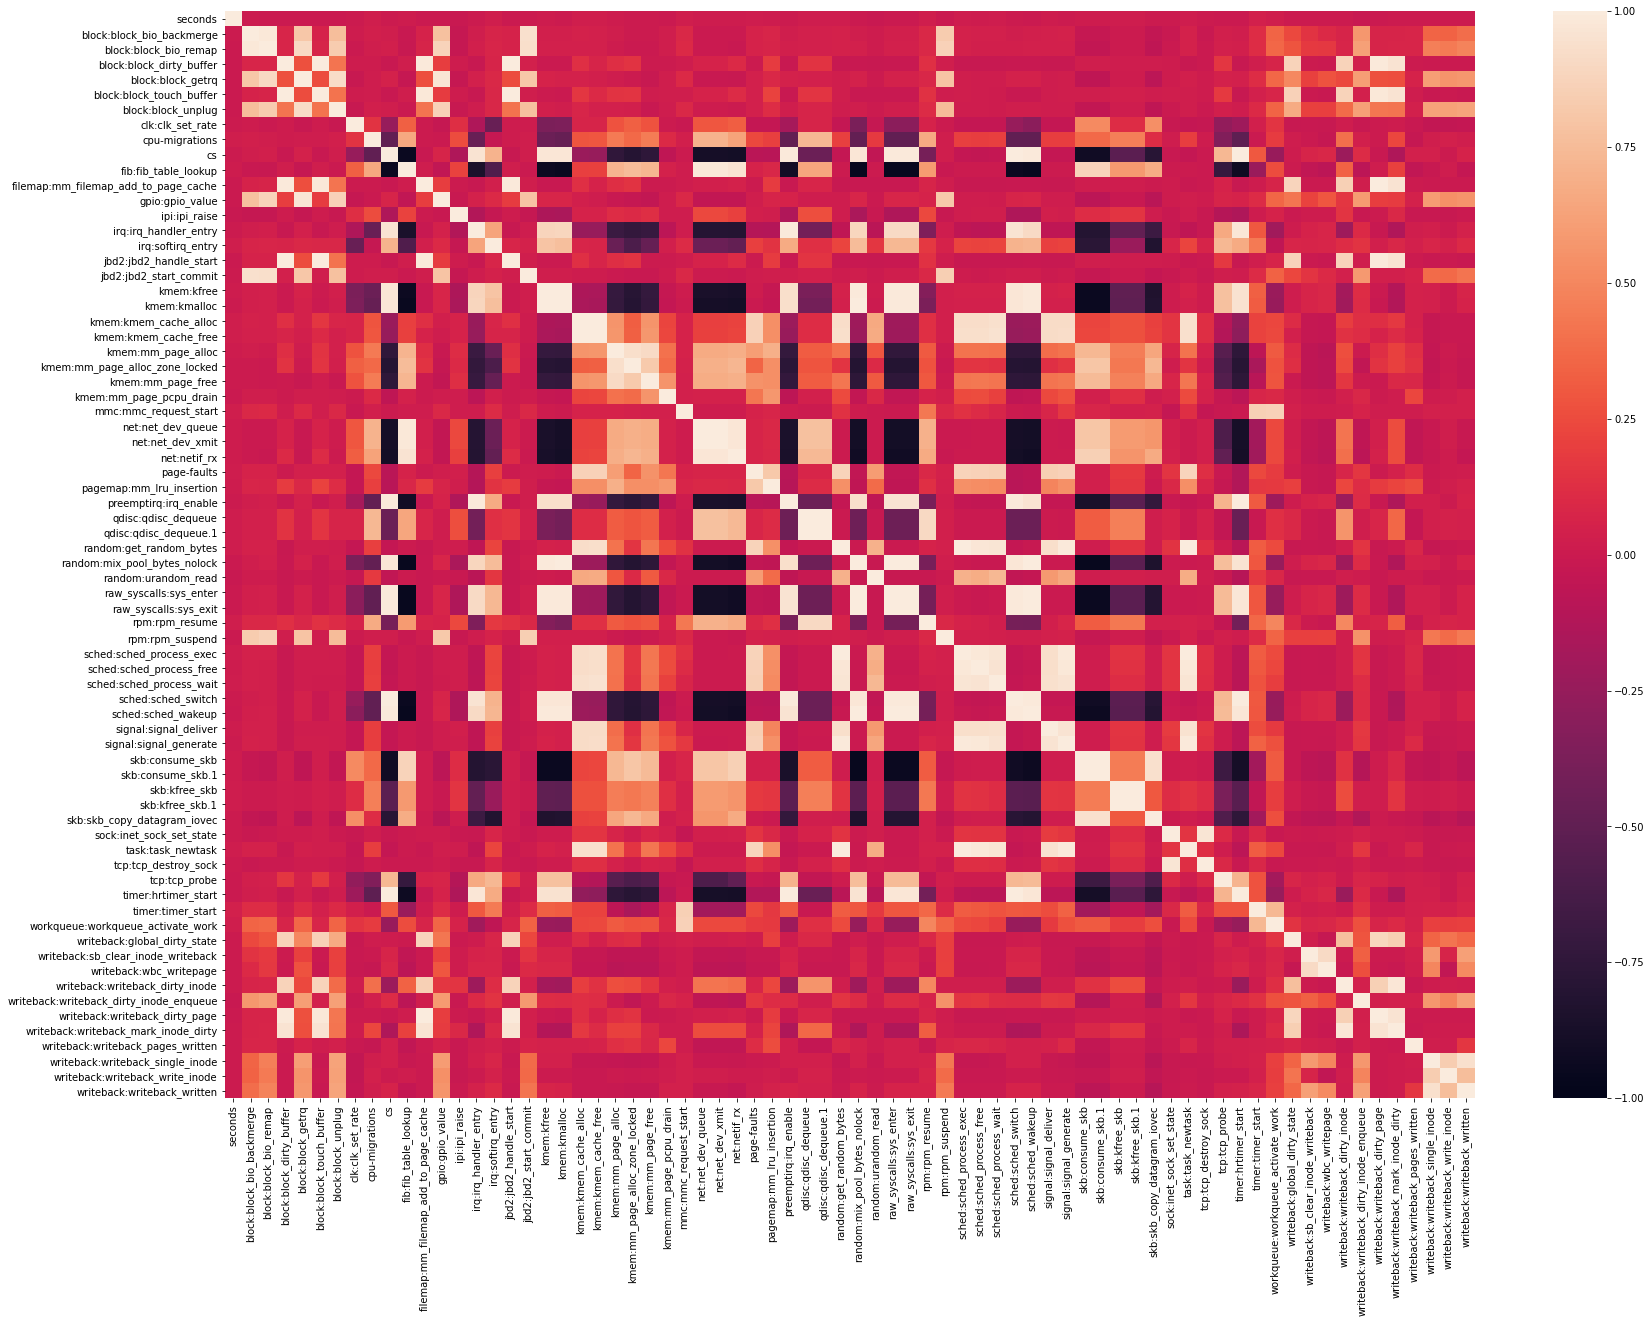

In [36]:
# Calculate the correlation between features

corr = df.corr()
f, ax = plt.subplots(figsize=(28, 20))
sn.heatmap(corr,vmin=-1.0,vmax=1.0)

In [37]:
# Split dataset in training and testing
X_train, X_test = train_test_split(df, test_size=0.10, random_state=42)
X_train.shape

(4805, 72)

In [38]:
#Save selected features
feat_list=X_train.columns

In [39]:
#Feature scaling

# Min_Max_Scaler normalization
#scaler = MinMaxScaler().fit(X_train)
#scaler = QuantileTransformer(n_quantiles=1000,random_state=42).fit(X_train)
#scaler = RobustScaler().fit(X_train)
scaler= StandardScaler().fit(X_train)
# Transform training set
X_train = scaler.transform(X_train)
# Transform test set
X_test = scaler.transform(X_test)

In [40]:
# Different models

#clf = IsolationForest(random_state=42, contamination=0.2)

"""detector_list=[AutoEncoder([32,16,32], hidden_activation='relu',epochs=20,contamination=0.1),
                LOF(contamination=0.1,n_neighbors=25), COPOD(contamination=0.1),
                IForest(random_state=42,contamination=0.1), CBLOF(n_clusters=20,contamination=0.1),
                HBOS(n_bins=100,contamination=0.1), LODA(n_bins=100,n_random_cuts=100,contamination=0.1)]"""
#clf = LSCP(detector_list)
#clf = AutoEncoder([16], hidden_activation='relu',epochs=20,contamination=0.2,dropout_rate=0.0,preprocessing=True)
#clf = LOF(contamination=0.05,n_neighbors=50)
#clf = CBLOF(n_clusters=20,contamination=0.2)
#clf = VAE(encoder_neurons=[32,16],decoder_neurons=[16,32],latent_dim=2,epochs=50,contamination=0.05,verbose=1)
#clf = LODA(n_bins=100,n_random_cuts=100,contamination=0.2)
#clf = COPOD(contamination=0.2)
#clf = HBOS(n_bins=100,contamination=0.2)
#clf = SO_GAAL(contamination=0.2)
#clf = MO_GAAL(contamination=0.2)
#clf = OCSVM(kernel='rbf',gamma=0.0001, nu=0.3)


"detector_list=[AutoEncoder([32,16,32], hidden_activation='relu',epochs=20,contamination=0.1),\n                LOF(contamination=0.1,n_neighbors=25), COPOD(contamination=0.1),\n                IForest(random_state=42,contamination=0.1), CBLOF(n_clusters=20,contamination=0.1),\n                HBOS(n_bins=100,contamination=0.1), LODA(n_bins=100,n_random_cuts=100,contamination=0.1)]"

In [41]:
# Model training

#clf.fit(X_train)

In [42]:
# Model evaluation with good behaviour
#pred=clf.predict(X_test)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [43]:
#MANUAL AUTOENCODER BUILD AND TRAIN
autoencoder=gen_autoencoder(X_train,[32,16,32])
es = EarlyStopping(monitor='val_loss', mode='min',patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
history = autoencoder.fit(X_train, X_train,epochs=2000,
                    batch_size=16,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[es, mc]).history
autoencoder = load_model('best_model.h5')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/2000
241/241 [==============================] - 15s 4ms/step - loss: 0.7035 - acc: 0.0410 - val_loss: 0.3251 - val_acc: 0.0916
Epoch 2/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.3190 - acc: 0.1101 - val_loss: 0.2344 - val_acc: 0.1446
Epoch 3/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.2883 - acc: 0.1731 - val_loss: 0.1910 - val_acc: 0.2529
Epoch 4/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.2452 - acc: 0.2530 - val_loss: 0.1663 - val_acc: 0.2029
Epoch 5/2000
241/241 [==============================] - 1s 3ms/step - loss: 0.2041 - acc: 0.2291 - val_loss: 0.1514 - val_acc: 0.2653
Epoch 6/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.2283 - acc: 0.2585 - val_loss: 0.1369 - val_acc: 0.2966
Epoch 7/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.1360 - acc: 0.3164 - val_loss: 0.1390 - val_acc: 0.2966
Epoch 8/2000
241/241 [==============================] - 1s 2m

Epoch 62/2000
241/241 [==============================] - 1s 3ms/step - loss: 0.0921 - acc: 0.6375 - val_loss: 0.0590 - val_acc: 0.6191
Epoch 63/2000
241/241 [==============================] - 1s 3ms/step - loss: 0.0418 - acc: 0.6424 - val_loss: 0.0413 - val_acc: 0.6670
Epoch 64/2000
241/241 [==============================] - 1s 2ms/step - loss: 0.0413 - acc: 0.6316 - val_loss: 0.0621 - val_acc: 0.6212
Epoch 65/2000
241/241 [==============================] - 1s 3ms/step - loss: 0.0363 - acc: 0.6657 - val_loss: 0.0408 - val_acc: 0.6379
Epoch 66/2000
241/241 [==============================] - 1s 2ms/step - loss: 0.0644 - acc: 0.6406 - val_loss: 0.0376 - val_acc: 0.6556
Epoch 67/2000
241/241 [==============================] - 1s 4ms/step - loss: 0.0411 - acc: 0.6489 - val_loss: 0.0355 - val_acc: 0.6691
Epoch 68/2000
241/241 [==============================] - 1s 2ms/step - loss: 0.0355 - acc: 0.6622 - val_loss: 0.0351 - val_acc: 0.6639
Epoch 69/2000
241/241 [==============================] 

241/241 [==============================] - 0s 2ms/step - loss: 0.0298 - acc: 0.7080 - val_loss: 0.0295 - val_acc: 0.6909
Epoch 123/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.0329 - acc: 0.7134 - val_loss: 0.0292 - val_acc: 0.7294
Epoch 124/2000
241/241 [==============================] - 1s 2ms/step - loss: 0.0330 - acc: 0.7190 - val_loss: 0.0290 - val_acc: 0.6629
Epoch 125/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.0387 - acc: 0.7157 - val_loss: 0.0435 - val_acc: 0.6743
Epoch 126/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.0337 - acc: 0.7119 - val_loss: 0.0394 - val_acc: 0.7024
Epoch 127/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.0376 - acc: 0.6928 - val_loss: 0.0285 - val_acc: 0.7003
Epoch 128/2000
241/241 [==============================] - 0s 2ms/step - loss: 0.0316 - acc: 0.7106 - val_loss: 0.0304 - val_acc: 0.7284
Epoch 129/2000
241/241 [==============================] - 0s 2m

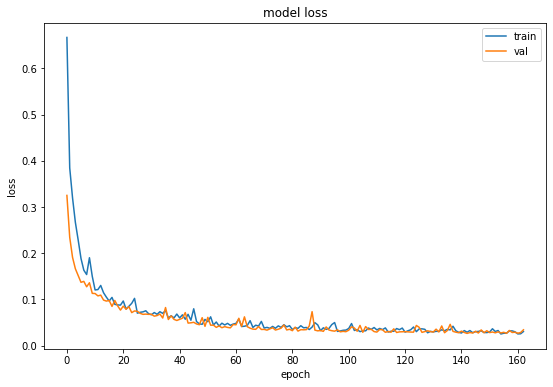

In [44]:
plt.figure(figsize=(9,6))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [45]:
#GET ANOMALY THRESHOLD
#autoencoder = load_model('best_model.h5')
#thresh = get_threshold_mse_percentage(autoencoder,X_train,0.1)
thresh = get_threshold_mse_iqr(autoencoder,X_train)
print(thresh)

[0.0389116977092578, -0.009769895431266792]


In [46]:
# Predict Anomalies contained in the normal behaviour
mad_outliers = detect_outliers(autoencoder, X_test, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [ 41 493]


In [47]:
##### Attack 1: SENDING FAKE PSD VALUES ####

In [48]:
df_fakepsd=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_fakePSD.csv")

In [49]:
df_fakepsd_1 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615452439000) & (df_fakepsd['timestamp'] <= 1615478400000)]
df_fakepsd_2 = df_fakepsd.loc[(df_fakepsd['timestamp'] >= 1615479600000) & (df_fakepsd['timestamp'] <= 1615485600000)]

df_fakepsd = pd.concat([df_fakepsd_1, df_fakepsd_2])
df_fakepsd.drop(['time','timestamp'],axis=1,inplace=True)

In [50]:
df_fakepsd = df_fakepsd.loc[(df_fakepsd['connectivity']==1)]

In [51]:
df_fakepsd = df_fakepsd[df_fakepsd.columns.intersection(feat_list)]

In [52]:
df_fakepsd = scaler.transform(df_fakepsd)

In [53]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [54]:
mad_outliers = detect_outliers(autoencoder, df_fakepsd, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [2679]


In [55]:
##### Attack 2: SENDING OUT PSD VALUES #### 

In [56]:
df_sendout=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_sendOut.csv")

In [57]:
df_sendout_1 = df_sendout.loc[(df_sendout['timestamp'] >= 1615795500000) & (df_sendout['timestamp'] <= 1615805280000)]
df_sendout_2 = df_sendout.loc[(df_sendout['timestamp'] >= 1615806000000) & (df_sendout['timestamp'] <= 1615809600000)]

df_sendout = pd.concat([df_sendout_1, df_sendout_2])
df_sendout.drop(['time','timestamp'],axis=1,inplace=True)

In [58]:
df_sendout = df_sendout.loc[(df_sendout['connectivity']==1)]

In [59]:
df_sendout = df_sendout[df_sendout.columns.intersection(feat_list)]

In [60]:
df_sendout = scaler.transform(df_sendout)

In [61]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [62]:
mad_outliers = detect_outliers(autoencoder, df_sendout, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [1122]


In [63]:
##### Attack 3: WRITE #### PRIVACY LEAKAGE

In [64]:
df_write=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_write.csv")

In [65]:
df_write = df_write.loc[(df_write['timestamp'] >= 1615834554000) & (df_write['timestamp'] <= 1615843200000)]

df_write.drop(['time','timestamp'],axis=1,inplace=True)

In [66]:
df_write = df_write.loc[(df_write['connectivity']==1)]

In [67]:
df_write = df_write[df_write.columns.intersection(feat_list)]

In [68]:
df_write = scaler.transform(df_write)

In [69]:
#pred=clf.predict(df_fakepsd)
#unique_elements, counts_elements = np.unique(pred, return_counts=True)
#print("\t",unique_elements,"    ",counts_elements)

In [70]:
mad_outliers = detect_outliers(autoencoder, df_write, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [708]


In [71]:
##### Attack 4: ADDING RANDOM NOISE TO PSD VALUES ####

In [72]:
# Data load
df_random=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_random.csv")

In [73]:
# Remove columns with constant values
df_random = df_random.loc[(df_random['connectivity']==1)]

In [74]:
# Filter vectors according to the timestamps
df_random_new = df_random.loc[(df_random['timestamp'] >= 1615913848000) & (df_random['timestamp'] <= 1615922405000)]

df_random_new.drop(['time','timestamp'],axis=1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [75]:
X_outliers6=df_random_new[df_random_new.columns.intersection(feat_list)]

In [76]:
# Transform outliers set
X_outliers6 = scaler.transform(X_outliers6)

In [77]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers6, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False]      [717]


In [78]:
##### Attack 5: EXCHANGE PSD VALUES OF TWO FREQUENCY BANDS ####
# Freq bands 90Mhz - [300Mhz - 1Ghz]

In [79]:
# Data load
df_exchange2=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_exchange.csv")

In [80]:
# Remove columns with constant values
df_exchange2 = df_exchange2.loc[(df_exchange2['connectivity']==1)]

In [81]:
# Filter vectors according to the timestamps
df_exchange2 = df_exchange2.loc[(df_exchange2['timestamp'] >= 1616585145000) & (df_exchange2['timestamp'] <= 1616589463000)]

df_exchange2.drop(['time','timestamp'],axis=1,inplace=True)

In [82]:
X_outliers9=df_exchange2[df_exchange2.columns.intersection(feat_list)]

In [83]:
# Transform outliers set
X_outliers9 = scaler.transform(X_outliers9)

In [84]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers9, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [241 106]


In [85]:
##### Attack 6: Hide a transmission ####
# 200Mhz - 250Mz

In [86]:
# Data load
df_hide=pd.read_csv("./Datasets/Rp3_3rd_capture/rp3_hide.csv")

In [87]:
# Remove columns with constant values
df_hide = df_hide.loc[(df_hide['connectivity']==1)]

In [88]:
# Filter vectors according to the timestamps
df_hide = df_hide.loc[(df_hide['timestamp'] >= 1616672277000) & (df_hide['timestamp'] <= 1616676574000)]

df_hide.drop(['time','timestamp'],axis=1,inplace=True)

In [89]:
X_outliers10 = df_hide[df_hide.columns.intersection(feat_list)]

In [90]:
# Transform outliers set
X_outliers10 = scaler.transform(X_outliers10)

In [91]:
#Outliers with manual autoencoder
mad_outliers = detect_outliers(autoencoder, X_outliers10, thresh)
unique_elements, counts_elements = np.unique(mad_outliers, return_counts=True)
print("\t",unique_elements,"    ",counts_elements)

	 [False  True]      [ 39 316]
